In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
n_genre = 15
def load_ratings():
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv('data/ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies():
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv('data/movies.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_users():
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv('data/users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def text2seq(text, n_genre):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq

In [9]:
ratings = load_ratings()
print(ratings.head())

   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291


In [10]:
movies = load_movies()
print(movies.head())

   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy


In [11]:
users = load_users()
print(users.head())

   uid user_fea1  user_fea2  user_fea3 user_fea4
0    1         F          1         10     48067
1    2         M         56         16     70072
2    3         M         25         15     55117
3    4         M         45          7     02460
4    5         M         25         20     55455


In [12]:
movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()
ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
ratings = ratings.join(users.set_index('uid'), on = 'uid', how = 'left')
print("====== preprocessed data =======")
ratings.head(100)

====== preprocessed data =======


,uid,mid,rating,timestamp,movie_name,movie_genre,user_fea1,user_fea2,user_fea3,user_fea4
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),"[1, 0, 0]",F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),"[9, 13, 0]",F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),"[13, 5, 0]",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),"[1, 0, 0]",F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)","[9, 2, 0]",F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
95,2,2490,3,978299966,Payback (1999),"[3, 4, 0]",M,56,16,70072
96,2,1834,4,978298813,"Spanish Prisoner, The (1997)","[1, 4, 0]",M,56,16,70072
97,2,3471,5,978298814,Close Encounters of the Third Kind (1977),"[1, 8, 0]",M,56,16,70072
98,2,589,4,978299773,Terminator 2: Judgment Day (1991),"[3, 8, 4]",M,56,16,70072


#### Define Input Layers

In [6]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

def define_input_layers():
    # numerical features
    fea3_input = Input((1,), name = 'input_fea3')
    num_inputs = [fea3_input]
    
    # single level categorical features
    uid_input = Input((1,), name = 'input_uid')
    mid_input = Input((1,), name= 'input_mid')
    cat_sl_inputs = [uid_input, mid_input]
    
    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name = 'input_genre')
    cat_ml_inputs = [genre_input]
    
    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    return inputs

inputs = define_input_layers()

In [7]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_mid, n_genre):
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_fea4')(fea3_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input), Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input)]
    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input)]
    
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

y_1d = fm_1d(inputs, 10, 10, 10)

#### Graph Diagram
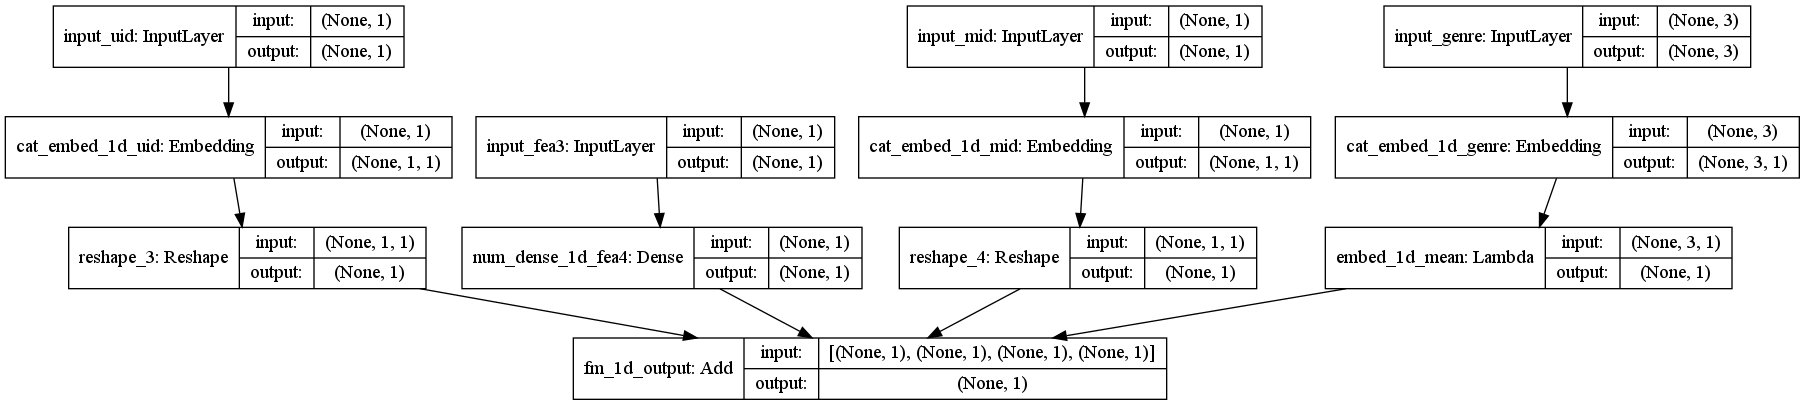

In [8]:
def fm_2d(inputs, n_uid, n_mid, n_genre, k):
    fea3_input, uid_input, mid_input, genre_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_fea3')(fea3_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)
    
    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input),
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)
    
    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)
    
    # calcuate the interactions by simplication: sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')
    
    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

y_fm2_d, embed_2d = fm_2d(inputs, 10, 10, 10, 5)

#### Graph Diagram
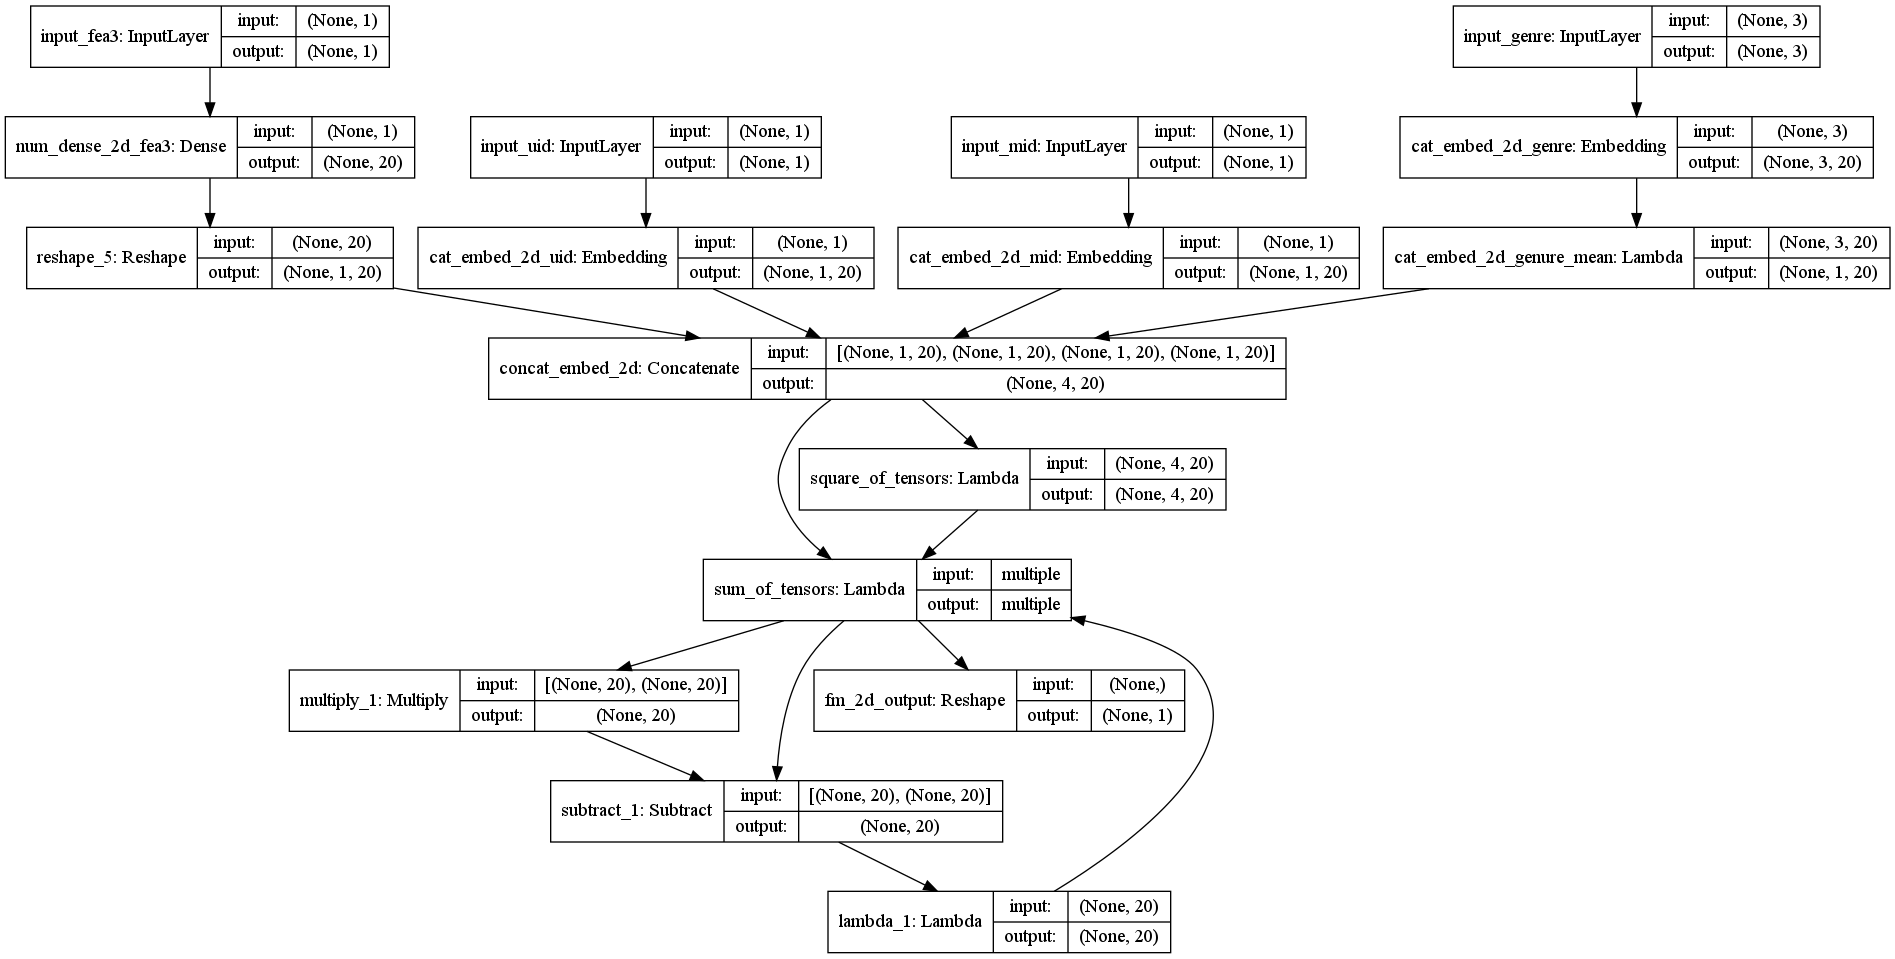

In [9]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = deep_part(embed_2d, [16, 16], 0.5)

#### Graph Diagram
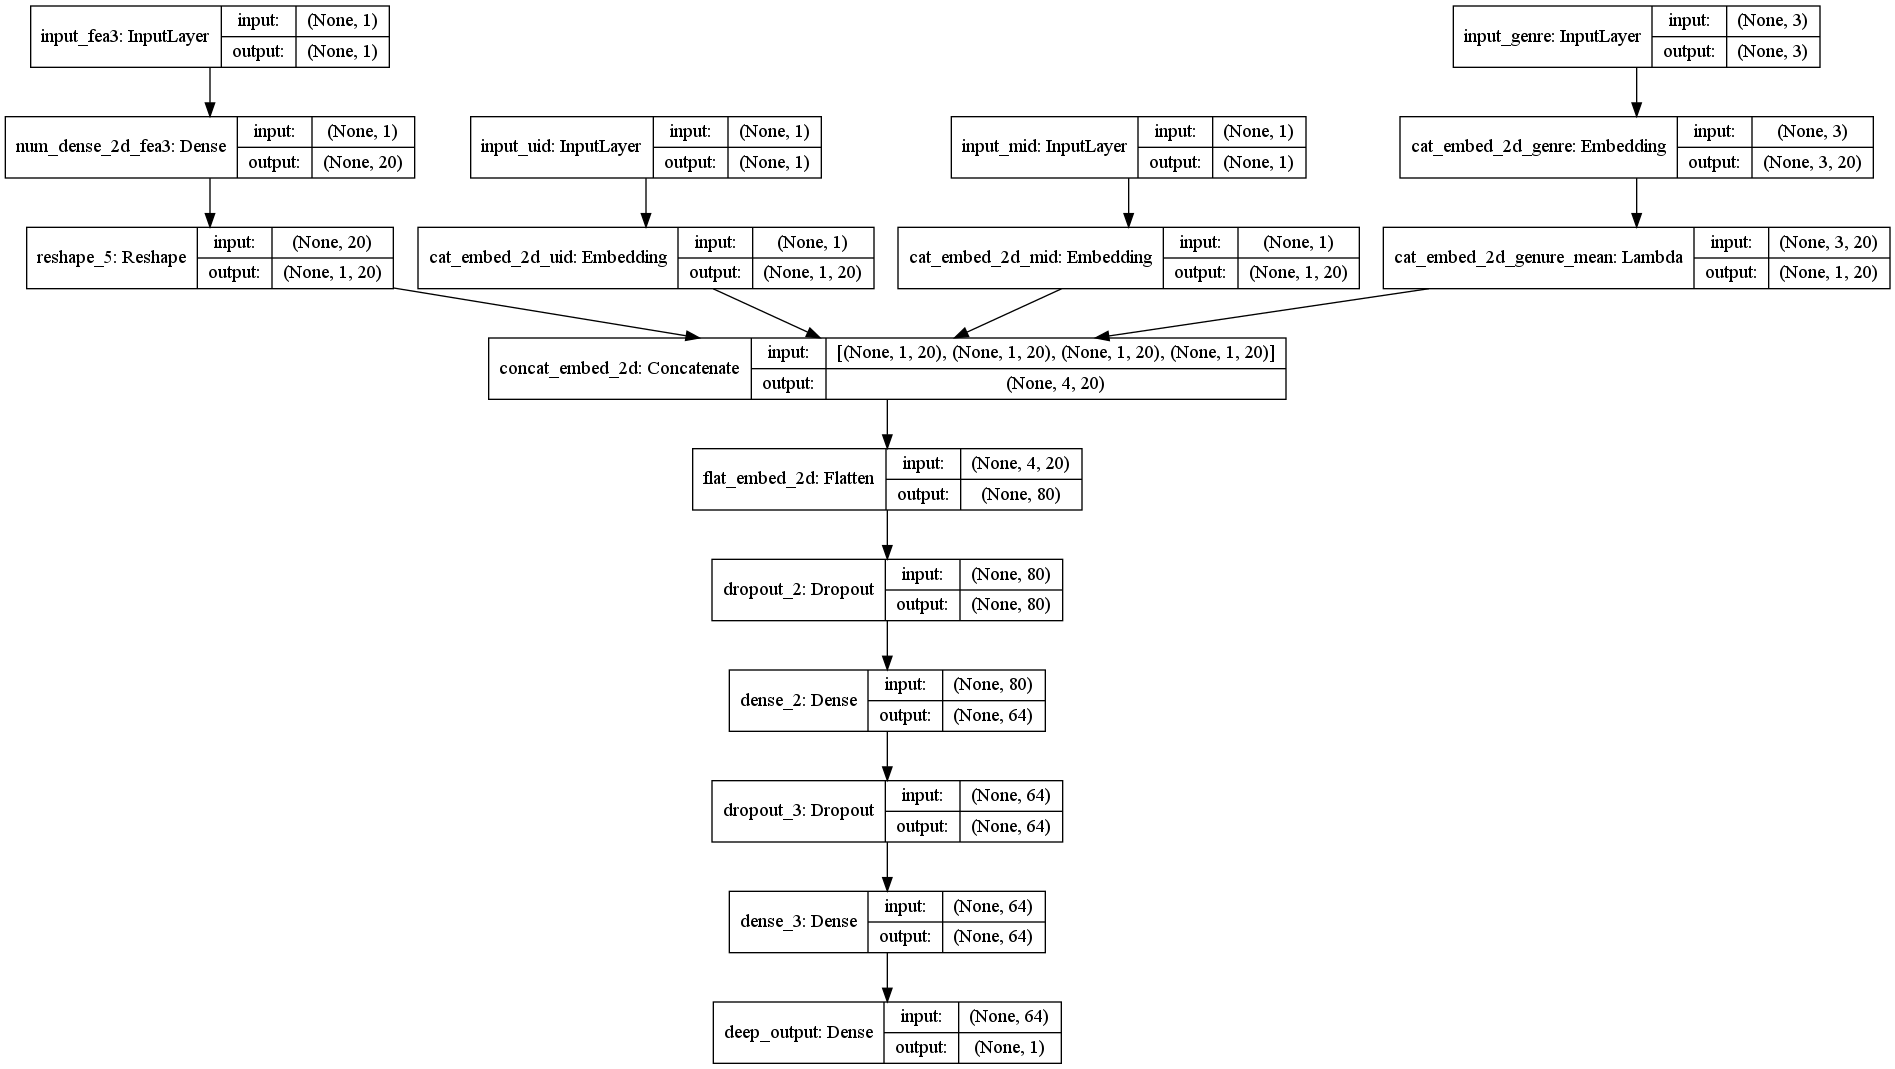

In [10]:
def deep_fm_model(n_uid, n_mid, n_genre, k, dnn_dim, dnn_dr):
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_uid, n_mid, n_genre)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_mid, n_genre, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

#### Graph Diagram
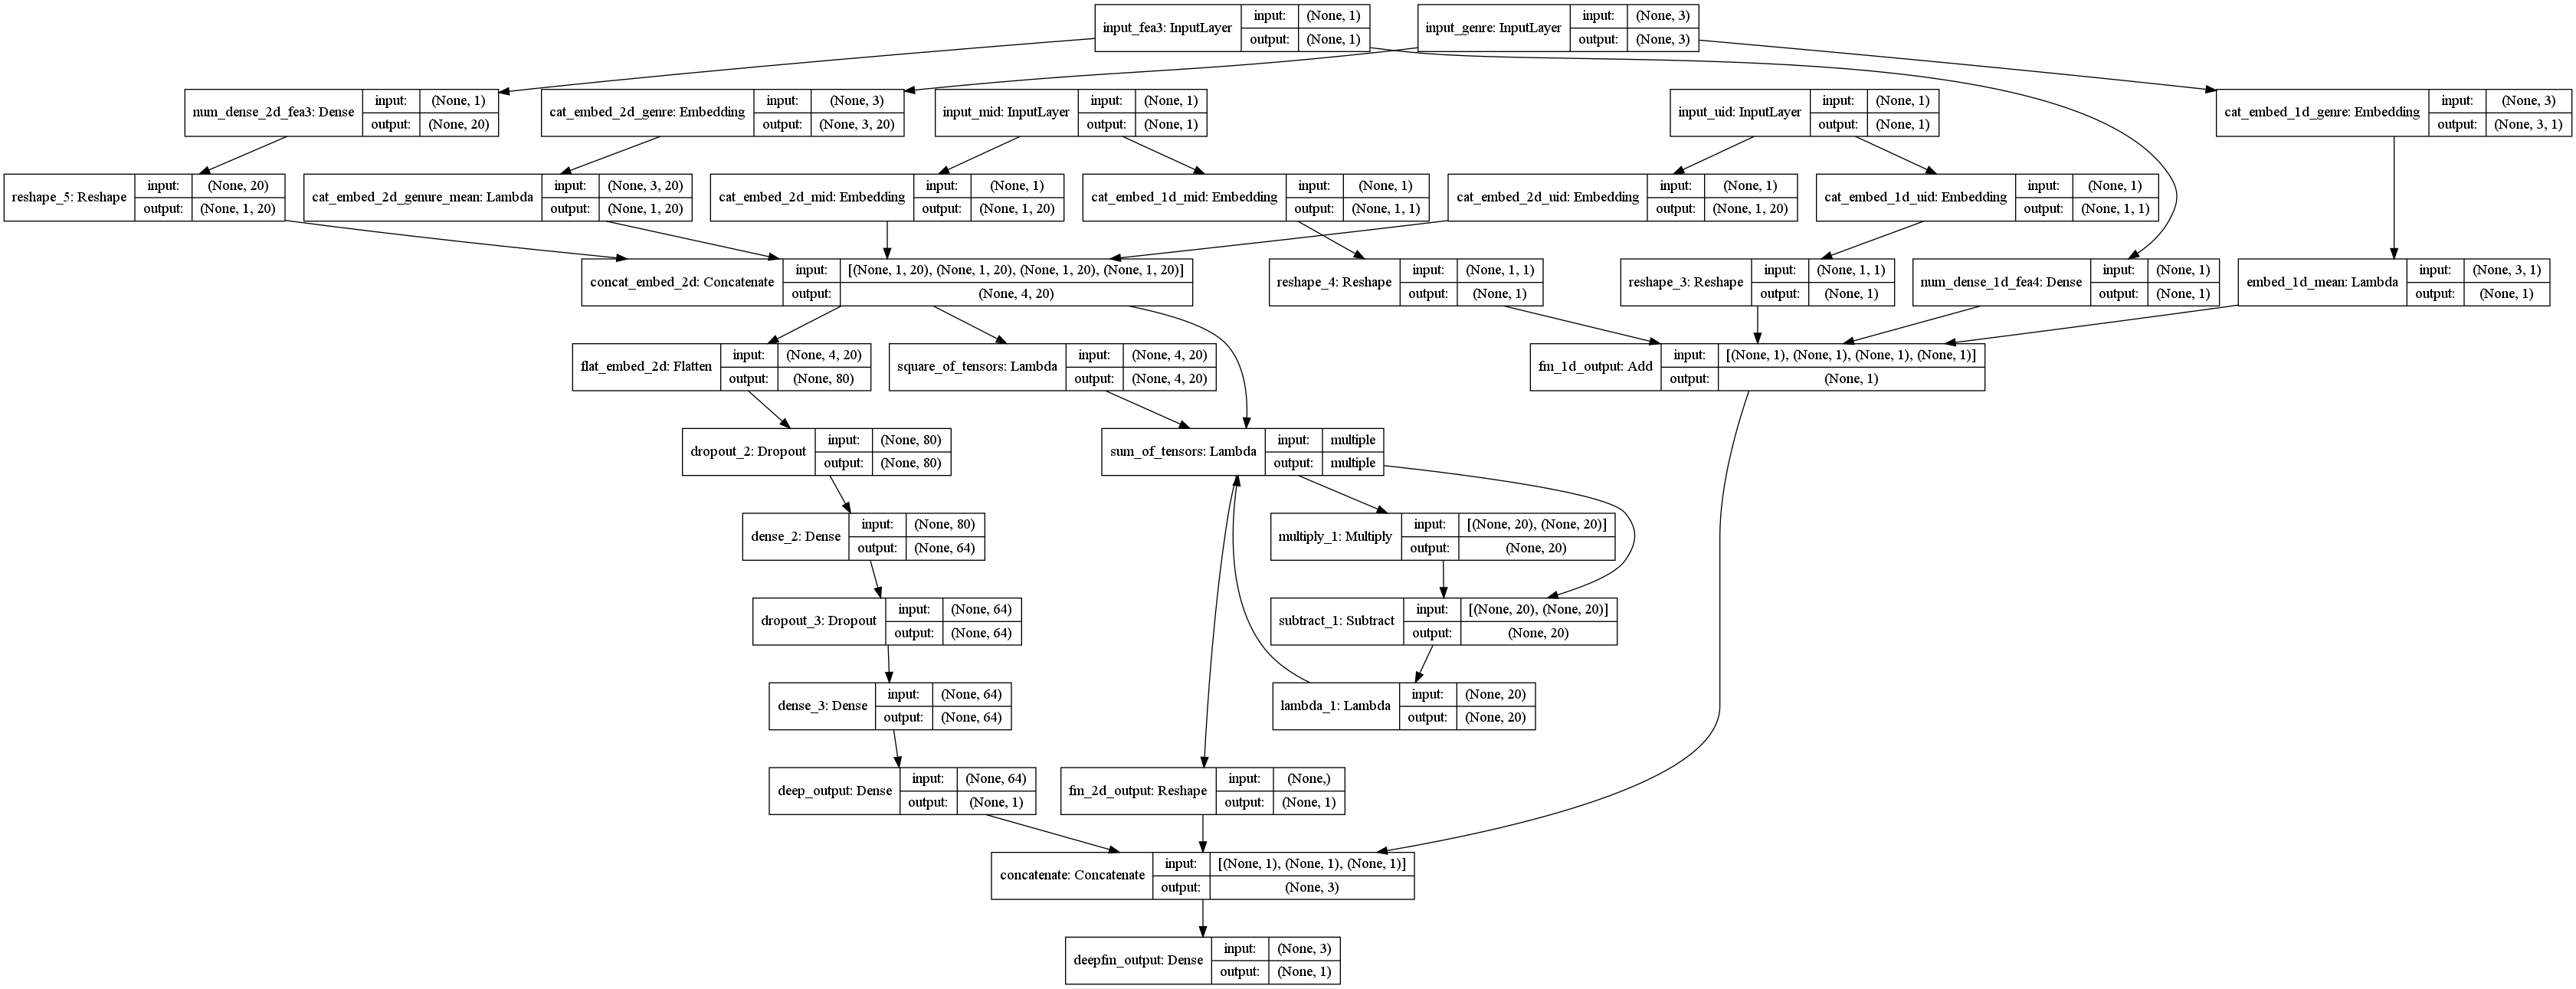

In [11]:
params = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_genre': 14,
    'k': 20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}
fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [12]:
def df2xy(ratings):
    x = [ratings.user_fea3.values,
         ratings.uid.values,
         ratings.mid.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3)]
    y = ratings.rating.values
    return x,y

in_train_flag = np.random.random(len(ratings)) <= 0.9
train_data = ratings.loc[in_train_flag,]
valid_data = ratings.loc[~in_train_flag,]
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [13]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# train  model
deep_fm_model.compile(loss = 'MSE', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='model/deepfm_weights.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
callbacks = [model_ckp, early_stop]
train_history = deep_fm_model.fit(train_x, train_y, epochs=100, batch_size=2048, validation_split=0.1, callbacks = callbacks)

Train on 809875 samples, validate on 89987 samples
Epoch 1/100
809875/809875 [==============================] - 3s 4us/sample - loss: 10.3304 - val_loss: 19.0988
Epoch 2/100
809875/809875 [==============================] - 2s 3us/sample - loss: 1.6236 - val_loss: 11.9762
Epoch 3/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.9966 - val_loss: 9.8540
Epoch 4/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.9180 - val_loss: 8.9281
Epoch 5/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.8891 - val_loss: 8.2213
Epoch 6/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.8735 - val_loss: 7.7806
Epoch 7/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.8645 - val_loss: 7.3905
Epoch 8/100
809875/809875 [==============================] - 2s 3us/sample - loss: 0.8570 - val_loss: 7.0878
Epoch 9/100
809875/809875 [==============================] - 2s 3us/sample

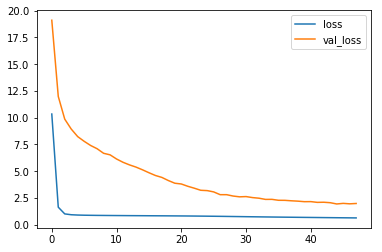

In [14]:
%matplotlib inline
pd.DataFrame(train_history.history).plot()

In [15]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: -0.493
    weight of 2nd order fm: 1.140
    weight of dnn part: -0.310



In [18]:
uid = 1975
# print(ratings[ratings['uid'] == uid].sort_values(by=['rating'], ascending=False).shape)
ratings[ratings['uid'] == uid].sort_values(by=['rating'], ascending=False)[:20]

,uid,mid,rating,timestamp,movie_name,movie_genre,user_fea1,user_fea2,user_fea3,user_fea4
334874,1975,2997,5,974684985,Being John Malkovich (1999),"[2, 0, 0]",M,18,4,97361
334885,1975,3253,5,974685129,Wayne's World (1992),"[2, 0, 0]",M,18,4,97361
334901,1975,2324,5,974684933,Life Is Beautiful (La Vita è bella) (1997),"[2, 1, 0]",M,18,4,97361
334905,1975,2700,5,974685083,"South Park: Bigger, Longer and Uncut (1999)","[2, 0, 0]",M,18,4,97361
334906,1975,3508,5,974685804,"Outlaw Josey Wales, The (1976)","[0, 0, 0]",M,18,4,97361
334909,1975,1914,5,974685083,Smoke Signals (1998),"[2, 1, 0]",M,18,4,97361
334890,1975,3494,5,974686168,True Grit (1969),"[7, 0, 0]",M,18,4,97361
334888,1975,216,5,974685329,Billy Madison (1995),"[2, 0, 0]",M,18,4,97361
334913,1975,34,5,974684719,Babe (1995),"[9, 2, 1]",M,18,4,97361
334899,1975,3114,5,974685083,Toy Story 2 (1999),"[9, 2, 0]",M,18,4,97361


In [19]:
"""
Making recommendations using our trained model is simple.
We only need to feed in a user and all books and then select the books which have the highest predicted ratings for that specific user.
note: ratings[(ratings.uid == 5) & (ratings['mid'].isin(recommended_movie_ids))]
"""
movie_ids = ratings.mid.unique()
predict_data = [np.array([users[users.uid == uid].user_fea3.values[0] for i in range(len(movie_ids))]),
                np.array([users[users.uid == uid].uid.values[0] for i in range(len(movie_ids))]),
                movie_ids,
                np.array([ratings[ratings.mid == movie_ids[i]].movie_genre.values[0] for i in range(len(movie_ids))])]
predictions = deep_fm_model.predict(predict_data)
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:20]
predictions[recommended_movie_ids]
movies[movies['mid'].isin(recommended_movie_ids)]

,mid,movie_name,movie_genre
14,15,Cutthroat Island (1995),"[3, 7, 5]"
66,67,Two Bits (1995),"[1, 0, 0]"
95,97,"Hate (Haine, La) (1995)","[1, 0, 0]"
125,127,"Silence of the Palace, The (Saimt el Qusur) (1...","[1, 0, 0]"
173,175,Kids (1995),"[1, 0, 0]"
196,198,Strange Days (1995),"[3, 10, 8]"
208,210,Wild Bill (1995),"[0, 0, 0]"
213,215,Before Sunrise (1995),"[1, 5, 0]"
241,244,Gumby: The Movie (1995),"[9, 0, 0]"
331,335,"Underneath, The (1995)","[14, 4, 0]"


In [ ]:
ratings[(ratings.uid == uid) & (ratings['mid'].isin(recommended_movie_ids))]